In [1]:
import pandas as pd
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

def get_runs_to_file(project_name="", file_name="forecasting_results_export_from_wandb.csv"):

    api = wandb.Api()
    runs = api.runs(project_name)
    runs_dict = {}

    # Initialize the dictionary with all possible keys
    for run in runs:
        run_keys = run.summary._json_dict.keys()
        for key in run_keys:
            if key == 'weekly_load_profile':
                continue

            if key not in runs_dict:
                runs_dict[key] = []
        config_keys = run.config.keys()
        for key in config_keys:
            if key not in runs_dict:
                runs_dict[key] = []
        if "name" not in runs_dict:
            runs_dict["name"] = []

    for i, run in enumerate(runs):
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        run_keys = run.summary._json_dict.keys()
        for key in run_keys:
            if key == 'weekly_load_profile':
                continue

            runs_dict[key].append(run.summary._json_dict[key])

        config_keys = run.config.keys()
        for key in config_keys:
            runs_dict[key].append(run.config[key])

        runs_dict["name"].append(run.name)

        for key, value in runs_dict.items():
            if len(value) < len(runs_dict["name"]):
                runs_dict[key].append("")

    runs_df = pd.DataFrame(runs_dict)
    runs_df.to_csv(f"./out/02_forecasting_single/{file_name}")

get_runs_to_file()

In [ ]:
g_df = pd.read_csv('../out/02_forecasting_single/forecasting_results_export_from_wandb.csv')
g_df.head()

In [ ]:
sorted_df = g_df.sort_values(by='test/loss_mse', ascending=True).head(10)
sorted_df

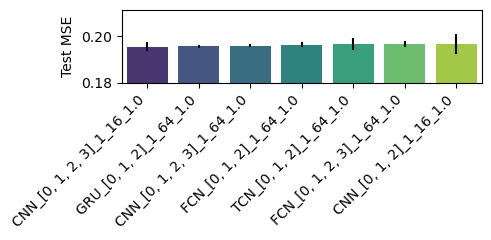

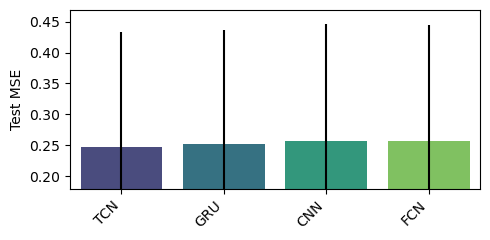

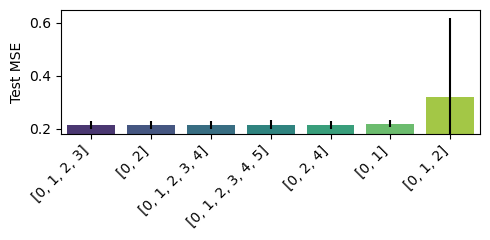

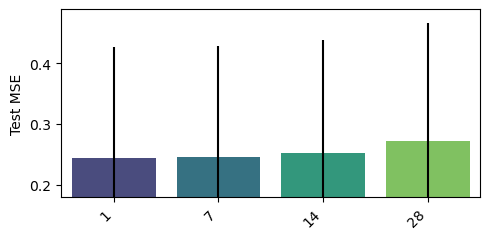

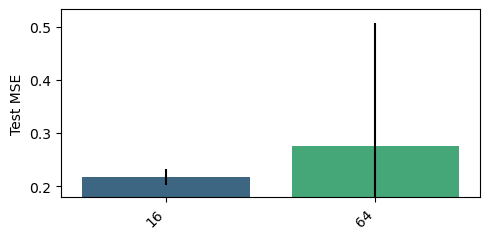

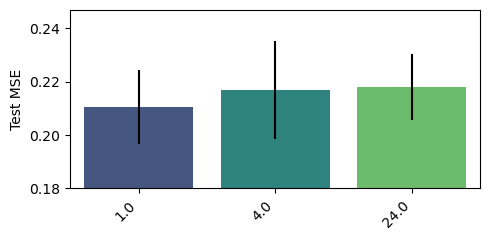

In [4]:
def plot_grouped_barplot(df, group_columns, sort_value='test/loss_mse', n_bars=7):
    """
    Plots a barplot for a DataFrame grouped by specified columns with error bars.

    Parameters:
    - df: Pandas DataFrame containing the data.
    - group_columns: list of strings, names of the columns to group the DataFrame by.
    - sort_value: string, name of the column to sort the values by (mean of the test/loss_mse).
    - n_bars: int, number of top bars to display based on sorted value.
    """
    
    # Grouping and aggregating the DataFrame
    df['model_name'] = df['model_name'].apply(lambda x: x.split('_')[0])
    grouped = df.groupby(group_columns)[sort_value]
    agg_df = grouped.agg(mean_test_loss_mse='mean', std_test_loss_mse='std').reset_index()


    # Creating a 'category' column for plotting
    agg_df['category'] = agg_df[group_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    
    # Sorting and selecting top n_bars
    agg_df = agg_df.sort_values(by='mean_test_loss_mse', ascending=True).head(n_bars)
    
    # Plotting
    plt.figure(figsize=(5, 2.5))
    barplot = sns.barplot(x='category', y='mean_test_loss_mse', data=agg_df, yerr=agg_df['std_test_loss_mse'], palette='viridis')
    
    plt.xlabel('')
    plt.ylim(0.18)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(f'Test MSE')
    # plt.title(f'Mean and Standard Deviation of {sort_value} by "{str.join(", ", group_columns)}"')
    plt.tight_layout()
    plt.savefig(f'out/plots/forecasting/hyperp_{str.join("_", group_columns)}_{sort_value.replace("/loss", "")}.png')
    plt.show()



plot_grouped_barplot(g_df, ["model_name", "features", "observation_days", "hidden_size", "step_size"])
plot_grouped_barplot(g_df, ["model_name"])
plot_grouped_barplot(g_df, ["features"])
plot_grouped_barplot(g_df, ["observation_days"])
plot_grouped_barplot(g_df, ["hidden_size"])
plot_grouped_barplot(g_df, ["step_size"])

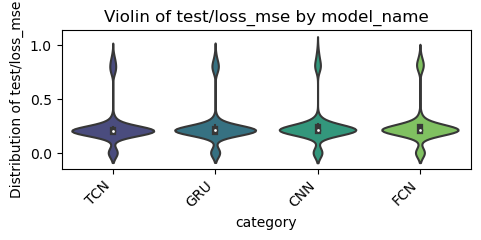

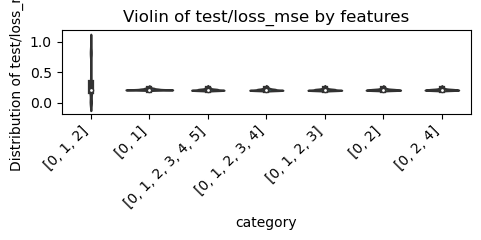

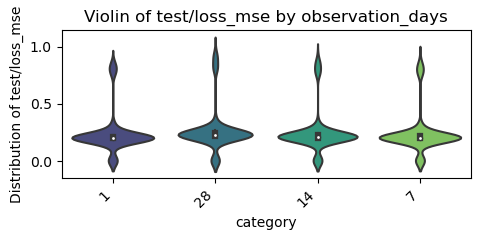

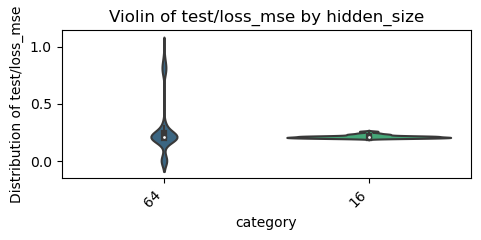

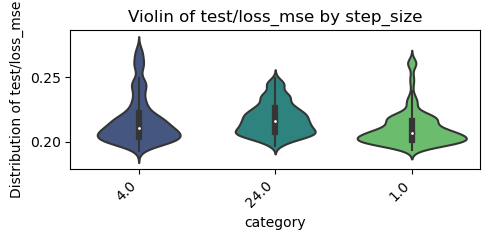

In [5]:
def plot_distribution(df, group_columns, sort_value='test/loss_mse', plot_type='violin', n_bars=10):
    """
    Generates a boxplot or violin plot for a DataFrame grouped by specified columns.

    Parameters:
    - df: Pandas DataFrame containing the data.
    - group_columns: list of strings, names of the columns to group the DataFrame by.
    - value_column: string, name of the numeric column to visualize.
    - plot_type: string, type of plot to generate ('boxplot' or 'violin').
    """
    
    # Aggregating the DataFrame to compute medians for sorting
    agg_df = df.groupby(group_columns)[sort_value].mean().reset_index().sort_values(by=sort_value, ascending=True)
    
    # Filtering the original DataFrame to keep only the top n_bars groups
    top_groups = pd.merge(df, agg_df[group_columns], on=group_columns, how='inner')

    # Creating a 'category' column for easier plotting
    top_groups['category'] = top_groups[group_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

    # Plotting
    plt.figure(figsize=(5, 2.5))
    if plot_type == 'boxplot':
        sns.boxplot(x='category', y=sort_value, data=top_groups, palette='viridis')
    elif plot_type == 'violin':
        sns.violinplot(x='category', y=sort_value, data=top_groups, palette='viridis')
    else:
        raise ValueError("plot_type must be either 'boxplot' or 'violin'")
    
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(f'Distribution of {sort_value}')
    # plt.xlabel('Group Categories')
    plt.title(f'{plot_type.capitalize()} of {sort_value} by {str.join(", ", group_columns)}')
    plt.tight_layout()
    plt.show()

# plot_distribution(g_df, ["model_name", "features", "observation_days", "hidden_size", "step_size"])
plot_distribution(g_df, ["model_name"])
plot_distribution(g_df, ["features"])
plot_distribution(g_df, ["observation_days"])
plot_distribution(g_df, ["hidden_size"])
plot_distribution(g_df, ["step_size"])